In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, callbacks, datasets
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Importing and Splitting Data

In [2]:
data = fetch_openml('Kuzushiji-MNIST')

In [3]:
X, t = data.data.to_numpy(), data.target.to_numpy()
X = X/255. # accomplishes the scaling
X = X.reshape((70000,28,28))
t = t.astype(np.uint8)

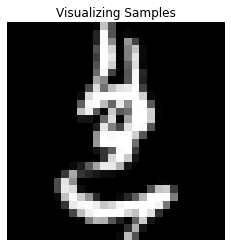

In [4]:
plt.imshow(X[34566], cmap='gray')
plt.axis('off')
plt.title('Visualizing Samples');

In [5]:
X_train, X_test, t_train, t_test = X[:60000], X[60000:], t[:60000], t[60000:]
X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, 
                                                  test_size = 0.20,
                                                  stratify = t_train,
                                                  random_state = 0)

# Tuning Stacked Autoencoder

### Tuning Bottleneck Size and Learning Rate

In [6]:
# Hyperparameters to tune: learning rate, beta values, bottleneck size, 
lr = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.1]
B1 = 0.9
B2 = 0.999
bottleneck = [10, 20, 50, 75, 100, 150]

scores = np.zeros((len(lr), len(bottleneck)))


In [13]:
for ii in range(len(bottleneck)):
    for jj in range(len(lr)):
        encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneck[ii],  activation='relu', use_bias=False)
        ])

        decoder = models.Sequential([
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(28*28, use_bias=False),
            layers.Reshape([28, 28])
        ])

        autoencoder = models.Sequential([encoder, decoder])

        autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                            optimizer=optimizers.Adam(learning_rate=lr[jj],
                            beta_1=B1,
                            beta_2=B2))
        
        callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = autoencoder.fit(X_train, X_train, epochs=50, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1,
                    verbose=0)
        
        scores[jj, ii] = min(history.history['val_loss'])

[[0.0432524  0.03659417 0.02626092 0.01831602 0.0156834  0.01228416]
 [0.04496935 0.04221988 0.02656882 0.02103805 0.01705976 0.01455829]
 [0.05571628 0.04508123 0.03096399 0.03131596 0.0234615  0.02072244]
 [0.06300911 0.06141164 0.05237832 0.05030794 0.04353024 0.04842895]
 [0.10334791 0.15768802 0.1034373  0.06292148 0.06606883 0.06259905]
 [0.15768802 0.15768802 0.08930925 0.0766583  0.07548341 0.08798049]
 [0.15768802 0.15768802 0.15768802 0.15768802 0.1059144  0.15768802]]


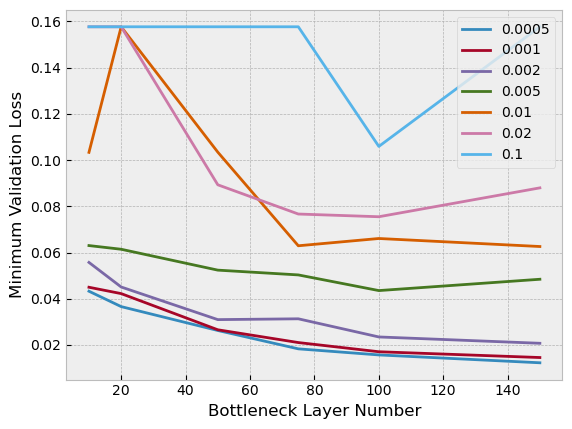

In [18]:
print(scores)
plt.figure()
plt.plot(bottleneck, scores[0,:])
plt.plot(bottleneck, scores[1,:])
plt.plot(bottleneck, scores[2,:])
plt.plot(bottleneck, scores[3,:])
plt.plot(bottleneck, scores[4,:])
plt.plot(bottleneck, scores[5,:])
plt.plot(bottleneck, scores[6,:])
plt.xlabel('Bottleneck Layer Number')
plt.ylabel('Minimum Validation Loss')
plt.title('Minimum Validation Loss vs. Bottleneck Size')
plt.legend(lr);

Larger bottleneck and smaller learning rate give better performance. 

### Experimenting with Larger Bottleneck Sizes
As expected, since ADAM helps learning overcome small local minimas, the validation loss in image reconstruction decreases with decreasing learning rate, as long as enough training time is given. Somewhat unexpected is how much increasing the number of nodes in the bottleneck layer increases performance. In PCA, to keep 99.9% of the explained variance of each image, only 16 dimensions are needed on average. But we continue to see much better berformance as we increase bottleneck layer nodes up to 150. The lowest value is in the corner of our grid, but for training time purposes, we will keep the learning rate at 0.0005 as lower learning rates may need many more iterations to properly train. We will now check more units in the bottleneck layer to see where we no longer gain extra performance

In [20]:
bottleneckNum  = [125, 150, 200, 250, 300, 350, 400]
scores2 = np.zeros(len(bottleneckNum))
lr = 0.0005

for ii in range(len(bottleneck)):
    
    encoder = models.Sequential([
        layers.Flatten(input_shape=[28,28]),
        layers.Dense(800,  activation='relu', use_bias=False),
        layers.Dense(200,  activation='relu', use_bias=False),
        layers.Dense(bottleneckNum[ii],  activation='relu', use_bias=False)
    ])

    decoder = models.Sequential([
        layers.Dense(200,  activation='relu', use_bias=False),
        layers.Dense(800,  activation='relu', use_bias=False),
        layers.Dense(28*28, use_bias=False),
        layers.Reshape([28, 28])
    ])

    autoencoder = models.Sequential([encoder, decoder])

    autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                        optimizer=optimizers.Adam(learning_rate=lr,
                        beta_1=B1,
                        beta_2=B2))
    
    callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = autoencoder.fit(X_train, X_train, epochs=100, 
                validation_data=(X_val, X_val),
                callbacks=callback1,
                verbose=0)
        
    scores2[ii] = min(history.history['val_loss'])

[0.01213735 0.01158006 0.00972538 0.0102109  0.00936456 0.00923875
 0.00920107]


Text(0, 0.5, 'Minimum Validation Loss')

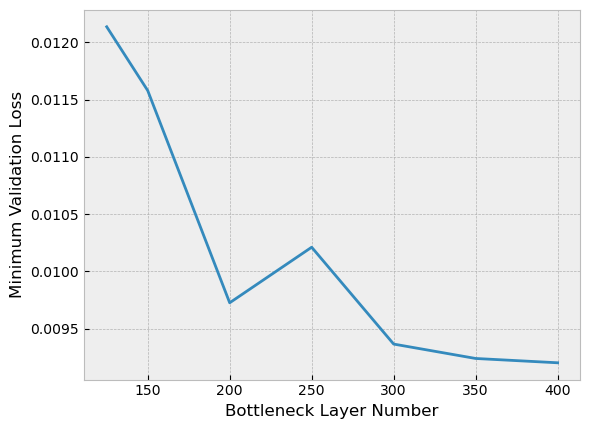

In [21]:
print(scores2)
plt.figure()
plt.plot(bottleneckNum, scores2)
plt.xlabel('Bottleneck Size')
plt.ylabel('MSE')
plt.title('Minimum Validation Loss vs. Bottleneck Size');

### Tuning Optimizer

In [22]:
# Tune the beta hyperparameters for adam to possibly increase convergence rate. Beta values need to be less than 1
bottleneckNum  = 200

lr = 0.0005
B1 = [0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975]
B2 = [0.995, 0.996, 0.997, 0.998, 0.999]
scores2 = np.zeros((len(B1),len(B2)))
numIter = np.zeros((len(B1),len(B2)))

for ii in range(len(B1)):
    
    for jj in range(len(B2)):
    
        encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneckNum,  activation='relu', use_bias=False)
        ])

        decoder = models.Sequential([
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(28*28, use_bias=False),
            layers.Reshape([28, 28])
        ])

        autoencoder = models.Sequential([encoder, decoder])

        autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                            optimizer=optimizers.Adam(learning_rate=lr,
                            beta_1=B1[ii],
                            beta_2=B2[jj]))
        
        callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = autoencoder.fit(X_train, X_train, epochs=100, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1,
                    verbose=0)
             
        scores2[ii, jj] = min(history.history['val_loss'])
        numIter[ii, jj] = len(history.history['val_loss'])

In [26]:
print(scores2.shape)
print(np.argmin(scores2))

print('Lowest Val loss was with beta 1 = ', B1[2], ' and beta 2 = ', B2[2])

(7, 5)
12
Lowest Val loss was with beta 1 =  0.875  and beta 2 =  0.997


### Training Final SAE

In [27]:
# Train Final Base SAE
bottleneckNum  = 200
lr = 0.0005
B1 = 0.875
B2 = 0.997

encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneckNum,  activation='relu', use_bias=False)
        ])

decoder = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                    optimizer=optimizers.Adam(learning_rate=lr,
                    beta_1=B1,
                    beta_2=B2))

callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

historySAE = autoencoder.fit(X_train, X_train, epochs=100, 
            validation_data=(X_val, X_val),
            callbacks=callback1,
            verbose=1)

Epoch 1/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0370 - val_loss: 0.0249
Epoch 2/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0228 - val_loss: 0.0211
Epoch 3/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0201 - val_loss: 0.0192
Epoch 4/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0187 - val_loss: 0.0179
Epoch 5/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 6/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 7/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0165 - val_loss: 0.0161
Epoch 8/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0161 - val_loss: 0.0159
Epoch 9/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 10/100
1500/1500 [==============================] - 2s 1ms/step - l

In [ ]:
# Evaluation
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
# Save the model weights
autoencoder.save_weights('SAE_weights.h5')
encoder.save_weights('SAE_encoder_weights.h5')
decoder.save_weights('SAE_decoder_weights.h5')

### Loading Trained SAE

In [40]:
bottleneck = 200

encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneck,  activation='relu', use_bias=False)
        ])

decoder = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

autoencoder = models.Sequential([encoder, decoder])

In [7]:
autoencoder.load_weights('SAE_weights.h5')
encoder = autoencoder.layers[0]
decoder = autoencoder.layers[1]

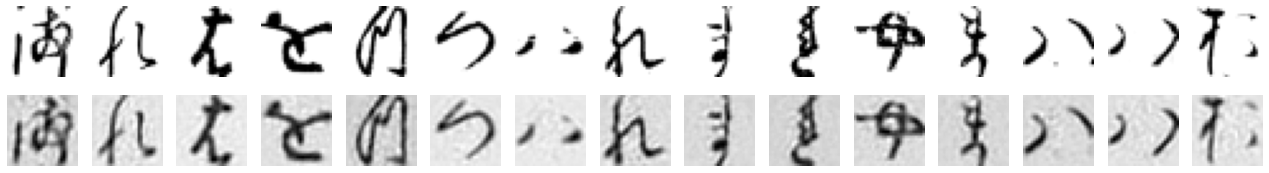

In [8]:
# visualize images reconstructed from encodings
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

def show_reconstructions(model, n_images=15):
    reconstructions = model.predict(X_val[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_val[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(autoencoder)

The reconstructions look really good!!

# Training a Classifier on Encoded Data

### Encoding Data

In [9]:
codings_train = encoder.predict(X_train)
codings_val = encoder.predict(X_val)
codings_test = encoder.predict(X_test)

### Triple-Layer MLP

#### Tuning Optimizer

In [11]:
learning_rate = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.1]
beta_1 = [0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975]
beta_2 = [0.995, 0.996, 0.997, 0.998, 0.999]

callback = callbacks.EarlyStopping(monitor = 'val_loss',
                                   patience = 10,
                                   restore_best_weights = True)

performance = np.zeros((len(learning_rate), len(beta_1), len(beta_2), 2))

In [13]:
for lr_idx, lr in np.ndenumerate(learning_rate):
    for B1_idx, B1 in np.ndenumerate(beta_1):
        for B2_idx, B2 in np.ndenumerate(beta_2):
            
            classifier = models.Sequential([
                layers.Input(shape=(200,)),
                layers.Dense(1024, activation = 'relu'),
                layers.Dense(512, activation = 'relu'),
                layers.Dense(256, activation = 'relu'),
                layers.Dense(10, activation = 'softmax')
            ])
            
            optimizer = optimizers.Nadam(learning_rate = lr, 
                                         beta_1 = B1,
                                         beta_2 = B2)

            classifier.compile(loss = 'sparse_categorical_crossentropy',
                               optimizer = optimizer,
                               metrics = ['accuracy'])
            
            start = time.time()
            history = classifier.fit(codings_train, t_train, epochs = 500,
                                     batch_size = 4000,
                                     validation_data = (codings_val, t_val),
                                     callbacks = [callback])
            end = time.time()
            training_time = end - start
            
            clear_output()
            
            y_proba_test = classifier.predict(codings_test)
            y_test = np.argmax(y_proba_test, axis=1)
            acc = accuracy_score(t_test, y_test)
            
            performance[lr_idx, B1_idx, B2_idx, :] = (acc, training_time)

In [24]:
performance[:,:,:,0]

array([[[0.8774, 0.8887, 0.8911, 0.8976, 0.8888],
        [0.9002, 0.8902, 0.88  , 0.885 , 0.8879],
        [0.8892, 0.8893, 0.8718, 0.8613, 0.8823],
        [0.9023, 0.8738, 0.8871, 0.8931, 0.8826],
        [0.8684, 0.9044, 0.8973, 0.8967, 0.8715],
        [0.9049, 0.9034, 0.8956, 0.8875, 0.8964],
        [0.9038, 0.8983, 0.8958, 0.8873, 0.8956]],

       [[0.8737, 0.8631, 0.8756, 0.8608, 0.8471],
        [0.8493, 0.8427, 0.8445, 0.8581, 0.8459],
        [0.8794, 0.8434, 0.8774, 0.8332, 0.8665],
        [0.8727, 0.9038, 0.8821, 0.8512, 0.873 ],
        [0.8457, 0.8525, 0.8789, 0.8745, 0.8647],
        [0.8743, 0.875 , 0.8726, 0.8714, 0.8662],
        [0.8993, 0.8927, 0.903 , 0.867 , 0.868 ]],

       [[0.8194, 0.7925, 0.8433, 0.7632, 0.8199],
        [0.8364, 0.7755, 0.8384, 0.8349, 0.8266],
        [0.8488, 0.7954, 0.8394, 0.8319, 0.8447],
        [0.7893, 0.815 , 0.8198, 0.7811, 0.8376],
        [0.7896, 0.8227, 0.824 , 0.8343, 0.8069],
        [0.8236, 0.8186, 0.8423, 0.835 , 0.809

In [29]:
np.max(performance[0,:,:,0]), np.min(performance[0,:,:,1])

(0.9049, 30.56606650352478)

In [26]:
performance[0,:,:,0], performance[0,:,:,1]

(array([[0.8774, 0.8887, 0.8911, 0.8976, 0.8888],
        [0.9002, 0.8902, 0.88  , 0.885 , 0.8879],
        [0.8892, 0.8893, 0.8718, 0.8613, 0.8823],
        [0.9023, 0.8738, 0.8871, 0.8931, 0.8826],
        [0.8684, 0.9044, 0.8973, 0.8967, 0.8715],
        [0.9049, 0.9034, 0.8956, 0.8875, 0.8964],
        [0.9038, 0.8983, 0.8958, 0.8873, 0.8956]]),
 array([[33.07670093, 40.71153378, 41.91968346, 50.03164792, 42.96379328],
        [51.36066055, 40.91413856, 37.33817506, 35.99846363, 41.0764327 ],
        [39.6274159 , 42.02713251, 30.71072769, 30.80100203, 37.14700294],
        [57.30002284, 33.71800232, 37.73894882, 44.79678512, 37.7763114 ],
        [30.5660665 , 59.03017402, 49.68025947, 50.56671619, 36.30132675],
        [58.03210139, 59.02381134, 46.93946362, 40.51720333, 45.5286603 ],
        [49.33710146, 49.09124851, 50.4129889 , 45.99798465, 49.56252456]]))

In [27]:
print('Parameters chosen:')
print('Learning rate: 0.005')
print('Beta1: 0.825')
print('Beta2: 0.998')

Parameters chosen:
Learning rate: 0.005
Beta1: 0.825
Beta2: 0.998


#### Tuning Architecture

In [35]:
N1_vals = [64, 128, 256, 512, 1024]
N2_vals = [64, 128, 256, 512, 1024]
N3_vals = [64, 128, 256, 512, 1024]

learning_rate, beta_1, beta_2 = (0.0005, 0.825, 0.998)

optimizer = optimizers.Nadam(learning_rate = learning_rate, 
                                         beta_1 = beta_1,
                                         beta_2 = beta_2)

callback = callbacks.EarlyStopping(monitor = 'val_loss',
                                   patience = 10,
                                   restore_best_weights = True)

performance = np.zeros((len(N1_vals), len(N2_vals), len(N3_vals), 2))

In [36]:
train_time = 0
for N1_idx, N1 in np.ndenumerate(N1_vals):
    for N2_idx, N2 in np.ndenumerate(N2_vals):
        for N3_idx, N3 in np.ndenumerate(N3_vals):
            print('Training size:', (N1, N2, N3))
            print('Last training time:', train_time)
            
            classifier = models.Sequential([
                layers.Input(shape=(200,)),
                layers.Dense(N1, activation = 'relu'),
                layers.Dense(N2, activation = 'relu'),
                layers.Dense(N3, activation = 'relu'),
                layers.Dense(10, activation = 'softmax')
            ])

            classifier.compile(loss = 'sparse_categorical_crossentropy',
                               optimizer = optimizer,
                               metrics = ['accuracy'])
            
            start = time.time()
            history = classifier.fit(codings_train, t_train, epochs = 500,
                                     batch_size = 4000,
                                     validation_data = (codings_val, t_val),
                                     callbacks = [callback])
            end = time.time()
            train_time = end - start
            
            performance[N1_idx, N2_idx, N3_idx, :] = classifier.evaluate(codings_train, t_train)
            
            clear_output()

In [43]:
np.where(performance[:,:,:,1] == np.max(performance[:,:,:,1]))

(array([1]), array([4]), array([4]))

In [44]:
performance[:,:,:,1]

array([[[0.949875  , 0.94722915, 0.95985419, 0.96708333, 0.97704166],
        [0.95629168, 0.97060418, 0.97262502, 0.97210419, 0.97806251],
        [0.96981251, 0.97354168, 0.97689581, 0.98172915, 0.98812503],
        [0.97716665, 0.97652084, 0.97402084, 0.98491669, 0.98918748],
        [0.98456252, 0.98124999, 0.98783332, 0.99093747, 0.98710418]],

       [[0.95293748, 0.95885414, 0.96460414, 0.96704167, 0.97483331],
        [0.96741664, 0.96950001, 0.97393751, 0.97770834, 0.97910416],
        [0.96764582, 0.97525001, 0.98366666, 0.98656249, 0.98785418],
        [0.98049998, 0.9896875 , 0.98872918, 0.99139583, 0.99364585],
        [0.98960418, 0.98837501, 0.9926042 , 0.98841667, 0.99556249]],

       [[0.9691667 , 0.9691667 , 0.97462499, 0.97316664, 0.98043752],
        [0.97714585, 0.97193748, 0.97933334, 0.97822917, 0.98289585],
        [0.98185414, 0.97639585, 0.98293751, 0.98400003, 0.99058336],
        [0.98525   , 0.98704165, 0.99002081, 0.99141669, 0.98904169],
        [0.98735

In [87]:
N1_vals = [128, 256]
N2_vals = [512, 1024]
N3_vals = [512, 1024]

learning_rate, beta_1, beta_2 = (0.0005, 0.825, 0.998)

optimizer = optimizers.Nadam(learning_rate = learning_rate, 
                                         beta_1 = beta_1,
                                         beta_2 = beta_2)

callback = callbacks.EarlyStopping(monitor = 'val_loss',
                                   patience = 10,
                                   restore_best_weights = True)

performance = np.zeros((len(N1_vals), len(N2_vals), len(N3_vals), 2))

In [88]:
for N1_idx, N1 in np.ndenumerate(N1_vals):
    for N2_idx, N2 in np.ndenumerate(N2_vals):
        for N3_idx, N3 in np.ndenumerate(N3_vals):
            
            classifier = models.Sequential([
                layers.Input(shape=(200,)),
                layers.Dense(N1, activation = 'relu'),
                layers.Dense(N2, activation = 'relu'),
                layers.Dense(N3, activation = 'relu'),
                layers.Dense(10, activation = 'softmax')
            ])

            classifier.compile(loss = 'sparse_categorical_crossentropy',
                               optimizer = optimizer,
                               metrics = ['accuracy'])
            
            history = classifier.fit(codings_train, t_train, epochs = 500,
                                     batch_size = 4000,
                                     validation_data = (codings_val, t_val),
                                     callbacks = [callback],
                                     verbose = 0)
            
            print('Training complete for:', (N1, N2, N3))
            
            performance[N1_idx, N2_idx, N3_idx, :] = classifier.evaluate(codings_val, t_val)

Training complete for: (128, 512, 512)
375/375 [==============================] - 0s 925us/step - loss: 0.1488 - accuracy: 0.9567
Training complete for: (128, 512, 1024)
375/375 [==============================] - 0s 1ms/step - loss: 0.1510 - accuracy: 0.9568
Training complete for: (128, 1024, 512)
375/375 [==============================] - 0s 1ms/step - loss: 0.1448 - accuracy: 0.9557
Training complete for: (128, 1024, 1024)
375/375 [==============================] - 1s 1ms/step - loss: 0.1589 - accuracy: 0.9519
Training complete for: (256, 512, 512)
375/375 [==============================] - 0s 1ms/step - loss: 0.1519 - accuracy: 0.9546
Training complete for: (256, 512, 1024)
375/375 [==============================] - 1s 1ms/step - loss: 0.1515 - accuracy: 0.9557
Training complete for: (256, 1024, 512)
375/375 [==============================] - 0s 1ms/step - loss: 0.1424 - accuracy: 0.9568
Training complete for: (256, 1024, 1024)
375/375 [==============================] - 1s 1ms/step 

In [11]:
print('Best performing architecture: 256-1024-512')

Best performing architecture: 256-1024-512


### Trying Single-Layer MLP

In [93]:
N1_vals = [64, 128, 256, 512, 1024, 1536, 2048, 3072, 4096]

learning_rate, beta_1, beta_2 = (0.0005, 0.825, 0.998)

optimizer = optimizers.Nadam(learning_rate = learning_rate, 
                                         beta_1 = beta_1,
                                         beta_2 = beta_2)

callback = callbacks.EarlyStopping(monitor = 'val_loss',
                                   patience = 10,
                                   restore_best_weights = True)

performance = np.zeros((len(N1_vals), 2))

In [85]:
for N1_idx, N1 in np.ndenumerate(N1_vals):

    classifier = models.Sequential([
        layers.Input(shape=(200,)),
        layers.Dense(N1, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ])

    classifier.compile(loss = 'sparse_categorical_crossentropy',
                       optimizer = optimizer,
                       metrics = ['accuracy'])

    history = classifier.fit(codings_train, t_train, epochs = 500,
                             batch_size = 4000,
                             validation_data = (codings_val, t_val),
                             callbacks = [callback],
                             verbose = 0)
    print('Training complete for:', N1)

    performance[N1_idx, :] = classifier.evaluate(codings_val, t_val)

Training complete for: 64
375/375 [==============================] - 0s 559us/step - loss: 0.2730 - accuracy: 0.9203
Training complete for: 128
375/375 [==============================] - 0s 590us/step - loss: 0.2397 - accuracy: 0.9303
Training complete for: 256
375/375 [==============================] - 0s 687us/step - loss: 0.1783 - accuracy: 0.9468
Training complete for: 512
375/375 [==============================] - 0s 751us/step - loss: 0.1501 - accuracy: 0.9548
Training complete for: 1024
375/375 [==============================] - 0s 752us/step - loss: 0.1308 - accuracy: 0.9625
Training complete for: 1536
375/375 [==============================] - 0s 893us/step - loss: 0.1313 - accuracy: 0.9614
Training complete for: 2048
375/375 [==============================] - 0s 834us/step - loss: 0.1352 - accuracy: 0.9597
Training complete for: 3072
375/375 [==============================] - 0s 951us/step - loss: 0.1331 - accuracy: 0.9603
Training complete for: 4096
375/375 [================

In [12]:
print('Best performing architecture: 4096')

Best performing architecture: 4096


### Training and Evaluating Final Codings Classifier

#### Performance of Triple-Layer

In [13]:
optimizer = optimizers.Nadam(learning_rate = 0.0005, 
                                   beta_1 = 0.825, beta_2 = 0.998)

callback = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 20,
                                         restore_best_weights = True)

In [15]:
classifier_triple = models.Sequential([
    layers.Input(shape=(200,)),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(1024, activation = 'relu'),
    layers.Dense(512, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
])

classifier_triple.compile(loss = 'sparse_categorical_crossentropy',
                   optimizer = optimizer,
                   metrics = ['accuracy'])

history = classifier_triple.fit(codings_train, t_train, epochs = 500,
                         batch_size = 1024,
                         validation_data = (codings_val, t_val),
                         callbacks = [callback],
                         verbose = 0)

In [16]:
y_proba_train = classifier_triple.predict(codings_train)
y_proba_test = classifier_triple.predict(codings_test)
y_train = np.argmax(y_proba_train, axis=1)
y_test = np.argmax(y_proba_test, axis=1)

Performance in training:
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0314 - accuracy: 0.9934


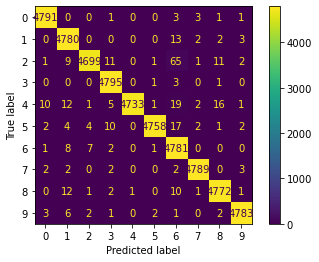

In [17]:
print('Performance in training:')
conf_mx = confusion_matrix(t_train, y_train)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
classifier_triple.evaluate(codings_train, t_train)
plt.savefig('CM_coding_classifier3_train.png');

Performance in test:
313/313 [==============================] - 0s 1ms/step - loss: 0.3849 - accuracy: 0.8930


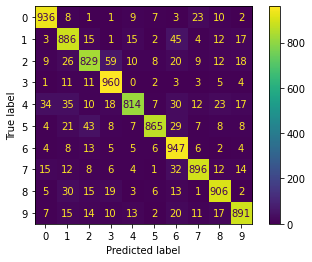

In [18]:
print('Performance in test:')
conf_mx = confusion_matrix(t_test, y_test)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
classifier_triple.evaluate(codings_test, t_test)
plt.savefig('CM_coding_classifier3_test.png');

#### Performance of Single-Layer

In [19]:
classifier_single = models.Sequential([
    layers.Input(shape=(200,)),
    layers.Dense(4096, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
])

classifier_single.compile(loss = 'sparse_categorical_crossentropy',
                   optimizer = optimizer,
                   metrics = ['accuracy'])

history = classifier_single.fit(codings_train, t_train, epochs = 500,
                         batch_size = 1024,
                         validation_data = (codings_val, t_val),
                         callbacks = [callback])

Epoch 1/500
47/47 [==============================] - 2s 32ms/step - loss: 1.9998 - accuracy: 0.5563 - val_loss: 1.1625 - val_accuracy: 0.7170
Epoch 2/500
47/47 [==============================] - 1s 28ms/step - loss: 1.0069 - accuracy: 0.7276 - val_loss: 0.8843 - val_accuracy: 0.7567
Epoch 3/500
47/47 [==============================] - 1s 30ms/step - loss: 0.8249 - accuracy: 0.7645 - val_loss: 0.7746 - val_accuracy: 0.7756
Epoch 4/500
47/47 [==============================] - 1s 29ms/step - loss: 0.7533 - accuracy: 0.7793 - val_loss: 0.7235 - val_accuracy: 0.7877
Epoch 5/500
47/47 [==============================] - 1s 29ms/step - loss: 0.7133 - accuracy: 0.7887 - val_loss: 0.7171 - val_accuracy: 0.7827
Epoch 6/500
47/47 [==============================] - 1s 30ms/step - loss: 0.6879 - accuracy: 0.7941 - val_loss: 0.6684 - val_accuracy: 0.7984
Epoch 7/500
47/47 [==============================] - 1s 31ms/step - loss: 0.6656 - accuracy: 0.8006 - val_loss: 0.6531 - val_accuracy: 0.8037
Epoch 

In [20]:
y_proba_train = classifier_single.predict(codings_train)
y_proba_test = classifier_single.predict(codings_test)
y_train = np.argmax(y_proba_train, axis=1)
y_test = np.argmax(y_proba_test, axis=1)

Performance in training:
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0225 - accuracy: 0.9978


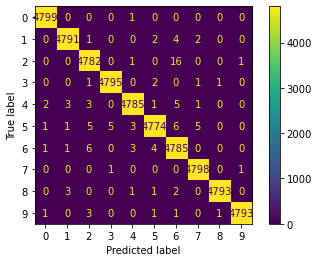

In [21]:
print('Performance in training:')
conf_mx = confusion_matrix(t_train, y_train)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
classifier_single.evaluate(codings_train, t_train)
plt.savefig('CM_coding_classifier1_train.png');

Performance in test:
313/313 [==============================] - 0s 990us/step - loss: 0.3413 - accuracy: 0.9061


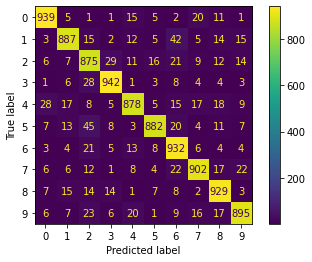

In [22]:
print('Performance in test:')
conf_mx = confusion_matrix(t_test, y_test)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
classifier_single.evaluate(codings_test, t_test)
plt.savefig('CM_coding_classifier1_test.png');

### Comparing to Project 1 Classifier

In [23]:
callback = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 10,
                                         restore_best_weights = True)

optimizer = optimizers.Nadam(learning_rate = 0.0005, 
                                   beta_1 = 0.825, beta_2 = 0.998)

Project1Classifier = models.Sequential([
    layers.Input(shape=(28,28)),
    layers.Flatten(),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
])

Project1Classifier.compile(loss = 'sparse_categorical_crossentropy',
         optimizer = optimizer,
         metrics = ['accuracy'])

history = Project1Classifier.fit(X_train, t_train, epochs = 500,
                    batch_size = 1024,
                    validation_data = (X_val, t_val),
                    callbacks = [callback],
                    verbose = 0)

In [24]:
y_proba_train = Project1Classifier.predict(X_train)
y_proba_test = Project1Classifier.predict(X_test)
y_train = np.argmax(y_proba_train, axis=1)
y_test = np.argmax(y_proba_test, axis=1)

Project 1 classifier performance in training:
1500/1500 [==============================] - 1s 829us/step - loss: 0.0299 - accuracy: 0.9970


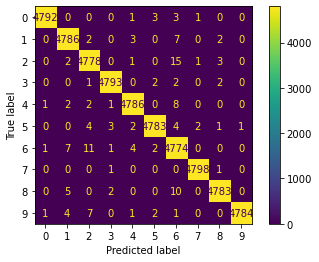

In [25]:
print('Project 1 classifier performance in training:')
conf_mx = confusion_matrix(t_train, y_train)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
Project1Classifier.evaluate(X_train, t_train)
plt.savefig('CM_project1_classifier_train.png');

Performance in test:
313/313 [==============================] - 0s 620us/step - loss: 0.4072 - accuracy: 0.8883


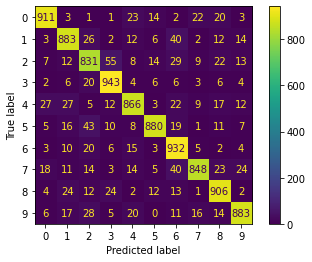

In [26]:
print('Performance in test:')
conf_mx = confusion_matrix(t_test, y_test)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
Project1Classifier.evaluate(X_test, t_test)
plt.savefig('CM_project1_classifier_test.png');

# Using SAE to Generate New Images

In [27]:
# sets apart a set of codings and labels with one from each class
other_condings, codings, other_labels, labels = train_test_split(codings_train, t_train, 
                                                  test_size = 10, # take ten samples
                                                  stratify = t_train, # t_train is evenly distributed in classes
                                                  random_state = 0)

In [28]:
def generate_images(codings, labels, stddev, decoder):
    '''give it a set of codings, one from each class, and it will make 1,000 new samples and their labels'''
    new_codings = codings
    new_labels = labels
    for i in np.arange(99): # this loop just copies the codings and labels enough to get 1000 samples
        new_codings = np.vstack((new_codings, codings))
        new_labels = np.hstack((new_labels, labels))
    noise = tf.random.normal(shape=tf.shape(new_codings), mean=0, stddev=stddev) # generate noise
    noisy_codings = new_codings + noise # add noise to codings
    new_images = decoder.predict(noisy_codings) # generate images from noisy codings
    return new_images, new_labels

In [29]:
new_images00, new_labels = generate_images(codings, labels, 0.0, decoder)
new_images01, new_labels = generate_images(codings, labels, 0.1, decoder)
new_images02, new_labels = generate_images(codings, labels, 0.2, decoder)
new_images05, new_labels = generate_images(codings, labels, 0.5, decoder)

Noise stddev = 0.0, 0.1, 0.2, and 0.5:


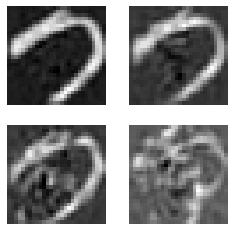

In [30]:
idx = 301
print('Noise stddev = 0.0, 0.1, 0.2, and 0.5:' )
plt.figure(figsize=(4,4))
plt.subplot(2,2,1)
plt.imshow(new_images00[idx], cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(new_images01[idx], cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(new_images02[idx], cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(new_images05[idx], cmap='gray')
plt.axis('off')
plt.savefig('images_with_noise.png');

### Project 1 Classifier Performance as a Function of Noise Variance

In [31]:
# here project1classifier was trained on X_train
y_proba = Project1Classifier.predict(new_images02)
y = np.argmax(y_proba, axis=1)

Performance of Project 1 classifier on new images with stddev=0.2:
32/32 [==============================] - 0s 650us/step - loss: 0.6398 - accuracy: 0.8060


[0.6398495435714722, 0.8059999942779541]

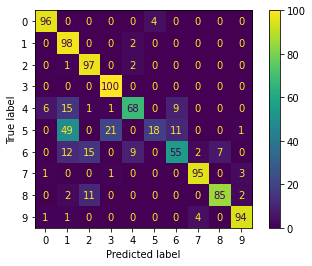

In [32]:
print('Performance of Project 1 classifier on new images with stddev=0.2:')
conf_mx = confusion_matrix(new_labels, y)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
Project1Classifier.evaluate(new_images02, new_labels)

Decent performance, but struggles with classes 4, 5 and 6.

Class 4, 5, and 6:


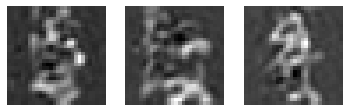

In [33]:
print('Class 4, 5, and 6:' )
plt.figure()
plt.subplot(1,3,1)
plt.imshow(new_images02[255], cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(new_images02[254], cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(new_images02[252], cmap='gray')
plt.axis('off');

In [34]:
y_proba = Project1Classifier.predict(new_images05)
y = np.argmax(y_proba, axis=1)

Performance of Project 1 classifier on new images with stddev=0.5:
32/32 [==============================] - 0s 672us/step - loss: 3.6660 - accuracy: 0.3940


[3.6659767627716064, 0.39399999380111694]

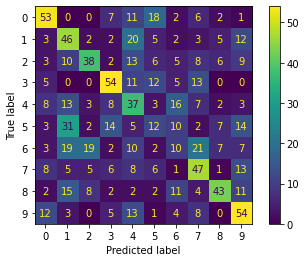

In [35]:
print('Performance of Project 1 classifier on new images with stddev=0.5:')
conf_mx = confusion_matrix(new_labels, y)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
Project1Classifier.evaluate(new_images05, new_labels)

More noise made for much worse performance.

In [36]:
stddev_vals = np.linspace(0, 2, 51)
accuracy00 = np.zeros((len(stddev_vals),2))

In [37]:
# seeing the performance of project1classifier when trained on just X_train
for idx, stddev in np.ndenumerate(stddev_vals):
    new_images, new_labels = generate_images(codings, labels, stddev, decoder)
    accuracy00[idx,:] = Project1Classifier.evaluate(new_images, new_labels)

32/32 [==============================] - 0s 722us/step - loss: 20.8067 - accuracy: 0.1400


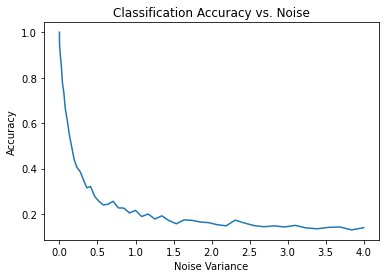

In [38]:
plt.figure()
plt.plot(stddev_vals**2, accuracy00[:,1])
plt.xlabel('Noise Variance')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy vs. Noise')
plt.savefig('AccVsNoise.png');

### Augmenting Training Data with Noisy Images

32/32 [==============================] - 0s 3ms/step - loss: 5.0237 - accuracy: 0.3280


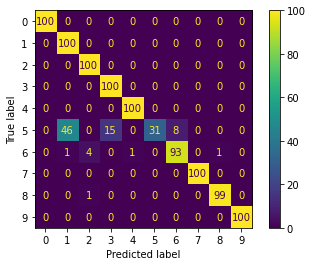

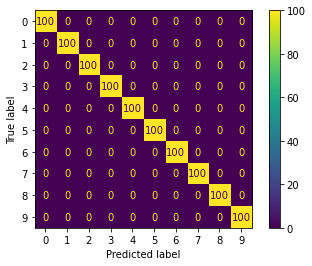

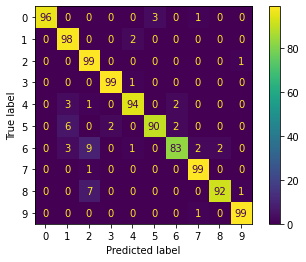

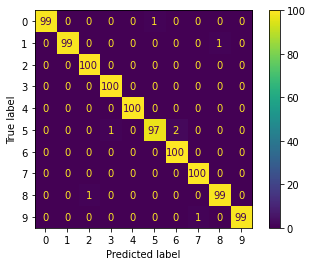

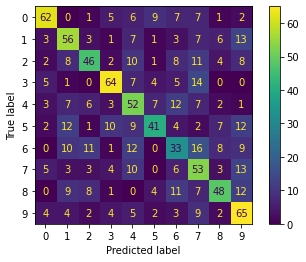

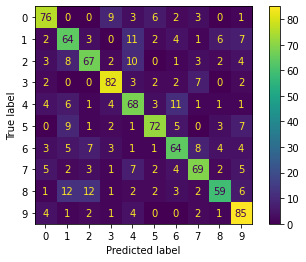

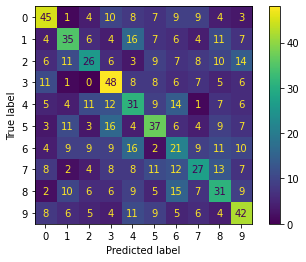

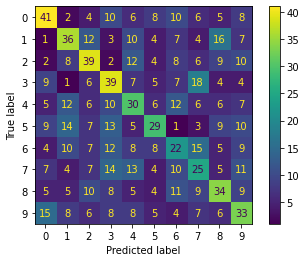

In [39]:
stddev_vals = [0.1,0.2,0.5,1.0]
accuracy = np.zeros((len(stddev_vals),2))

for idx, stddev in np.ndenumerate(stddev_vals):
    new_images, new_labels = generate_images(codings, labels, stddev, decoder)
    
    y_proba = Project1Classifier.predict(new_images)
    y = np.argmax(y_proba, axis=1)
    
    filename = 'CM_P1classifier_noisy_' + str(stddev) + '.png'
    conf_mx = confusion_matrix(new_labels, y)
    disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
    disp_cm.plot()
    Project1Classifier.evaluate(new_images, new_labels)
    plt.savefig(filename);
    
    noisy_train = np.vstack((X_train, new_images))
    noisy_labels = np.hstack((t_train, new_labels))
    
    Project1Classifier = models.Sequential([
    layers.Input(shape=(28,28)),
    layers.Flatten(),
    layers.Dense(4096, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
    ])

    Project1Classifier.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

    history = Project1Classifier.fit(noisy_train, noisy_labels, epochs = 500,
                        batch_size = 1024,
                        validation_data = (X_val, t_val),
                        callbacks = [callback])
    clear_output()
    
    new_images, new_labels = generate_images(codings, labels, stddev, decoder)
    
    y_proba = Project1Classifier.predict(new_images)
    y = np.argmax(y_proba, axis=1)
    
    filename = 'CM_P1classifier_noisy_' + str(stddev) + 'w_aug.png'
    conf_mx = confusion_matrix(new_labels, y)
    disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
    disp_cm.plot()
    Project1Classifier.evaluate(new_images, new_labels)
    plt.savefig(filename);

# Custom Loss Function
There are many possible loss functions for classification. However, for this project we have been given the template of using a distance formulation as such: $ R = 1/K\sum_{i=1}^{K} d_i $. We can make modifications to the lambda value that we multiply by R, the distance metric, the batch size K, and other implementation criteria. We will try euclidean distance (with latent space normalization), as well as a Manhattan block distance, and mahalanobis distances. Euclidian is a simple default and the normalization should ensure that distance is not dominated by whichever variable has the highest spread. Manhattan block distance [some reason]. Mahalanobis takes advantage of the variance to improve the distance metric.

In [62]:
# custom SAE loss
from sklearn.preprocessing import StandardScaler

class StackedAutoencoderLoss:
    # (tf.keras.losses.Loss)
    def __init__(self, lam=0.5, name="stacked_autoencoder_loss", distance_type = 'l2', prior_dir='sparse'):
        """
        Initialize the loss class.

        Args:
            lam (float): Weighting factor for the custom latent space loss component.
            name (str): Name of the loss.
            distance_type (str): one of 'l1', 'l2', or 'linf' describing the three distance types
            prior_dir (str): either 'sparse' for a sparse encoding or 'dense' for a Gram Schmidt dense matrix
        """
        # super().__init__(name=name)
        self.lam = lam
        self.distance_type = distance_type
        self.prior_dir = prior_dir
        

    def __call__(self, y_true, y_pred, latent_space=None, prior=None):
        if prior is None:
            raise ValueError("Prior argument is required.")
        
        if latent_space is None:
            raise ValueError("Latent space argument is required.")
        """
        Compute the combined loss.

        Args:
            y_true (Tensor): Tensor of true input values for reconstruction (e.g., autoencoder input).
            y_pred (Tensor): Tensor of reconstructed values (autoencoder output).
            latent_space (Tensor): Tensor representing the latent space embeddings.
            prior (Int): Integer of the for the input's class.
         

        Returns:
            A scalar Tensor representing the combined loss value.
        """
        # print(f"y_true shape: {y_true.shape}")
        # print(f"y_pred shape: {y_pred.shape}")
        # print(f"latent_space shape: {latent_space.shape}")
        # print(f"prior shape: {prior.shape}")
        
        # Get batch size
        batch_size = tf.shape(y_true)[0]
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Get latent_space and prior length
        latent_dim = latent_space.shape[-1]
        num_classes = 10
        
        # Reconstruction loss (MSE) across all elements in the batch
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred), axis=(1, 2))  # Adjust axes for your data shape

        # Make prior direction
        if self.prior_dir == 'sparse':
            prior_directions = self.generate_orthogonal_directions(num_classes, latent_dim)
            
        elif self.prior_dir == 'dense':
            prior_directions = self.generate_dense_orthogonal_directions(num_classes, latent_dim)
            
        else:
            raise ValueError("Prior direction may only be 'dense' or 'sparse'.")
        
        # Get the distance measure
        # selected_prior_direction = prior_directions[prior, :]
        prior_casted = tf.cast(prior, tf.int32)
        selected_prior_direction = tf.gather(prior_directions, prior_casted, axis=0)
        
        latent_space_casted = tf.cast(latent_space, tf.float32)
        selected_prior_direction_casted = tf.cast(selected_prior_direction, tf.float32)

        # Compute latent space distance based on the specified metric
        if self.distance_type == 'l1':
            # L1 distance: Sum of absolute differences
            latent_loss = tf.reduce_mean(tf.abs(latent_space_casted - selected_prior_direction_casted), axis=1)
        elif self.distance_type == 'l2':
            # L2 distance: Euclidean distance (squared differences)
            latent_loss = tf.reduce_mean(tf.square(latent_space_casted - selected_prior_direction_casted), axis=1)
        elif self.distance_type == 'linf':
            # Linf distance: Maximum absolute difference
            latent_loss = tf.reduce_max(tf.abs(latent_space_casted - selected_prior_direction_casted), axis=1)
        else:
            raise ValueError("Distance type must be 'l1', 'l2', or 'linf'.")
        

        # Latent space loss (e.g., L2 distance to prior)
        latent_loss = latent_loss / tf.cast(batch_size, tf.float32)
        
        mse_loss = tf.reduce_mean(mse_loss)  # Reduce to a scalar
        latent_loss = tf.reduce_mean(latent_loss) 

        # Combine both losses per sample in the batch
        total_loss = (self.lam * mse_loss) + ((1- self.lam) * latent_loss)

        # Average over the batch
        return tf.reduce_mean(total_loss)
    
    def generate_dense_orthogonal_directions(self, num_classes, latent_dim, seed=10):
        """
        Generate dense orthogonal target directions using Gram-Schmidt process.

        Args:
            num_classes (int): Number of classes.
            latent_dim (int): Dimensionality of the latent space.

        Returns:
            np.ndarray: Array of shape (num_classes, latent_dim) containing dense orthogonal unit vectors.
        """
        if num_classes > latent_dim:
            raise ValueError("Number of classes cannot exceed latent space dimensionality.")

        np.random.seed(seed)
        # Start with random vectors
        random_vectors = np.random.randn(num_classes, latent_dim)

        # Apply Gram-Schmidt process to orthogonalize
        orthogonal_vectors = []
        for v in random_vectors:
            for u in orthogonal_vectors:
                v -= np.dot(v, u) * u  # Subtract projection
            v = v / np.linalg.norm(v)  # Normalize
            orthogonal_vectors.append(v)
        
        return np.array(orthogonal_vectors)
    
    def generate_orthogonal_directions(self, num_classes, latent_dim):
        """
        Generate orthogonal target directions in latent space.

        Args:
            num_classes (int): Number of classes.
            latent_dim (int): Dimensionality of the latent space.

        Returns:
            np.ndarray: Array of shape (num_classes, latent_dim) containing orthogonal unit vectors.
        """
        if num_classes > latent_dim:
            raise ValueError("Number of classes cannot exceed latent space dimensionality.")

        # Start with an identity matrix for orthogonal vectors
        identity_matrix = np.eye(latent_dim)

        # Select the first num_classes rows
        target_directions = identity_matrix[:num_classes]

        return target_directions

In [ ]:
batch_size = 32  # Example batch size

# Create the training dataset with class labels
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, t_train))  # Pair images with labels
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=1000)

# Create the validation dataset with class labels
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, t_val))  # Pair images with labels
val_dataset = val_dataset.batch(batch_size)

bottleneck  = 200
lr = 0.0005
B1 = 0.875
B2 = 0.997

encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneck,  activation='relu', use_bias=False)
        ])

decoder = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

# Custom Training Loop
class CustomAutoencoder(tf.keras.Model):
    def __init__(self, encoder, decoder, loss_fn):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.loss_fn = loss_fn

    def call(self, x):
        latent_space = self.encoder(x)
        y_pred = self.decoder(latent_space)
        return y_pred, latent_space
    
loss_fn = StackedAutoencoderLoss(lam=0.5, distance_type = 'l2', prior_dir='dense')

# Create the autoencoder with encoder, decoder
autoencoder_model = CustomAutoencoder(encoder, decoder, loss_fn)

# Optimizer same as the best from before
optimizer = optimizers.Adam(learning_rate=lr, beta_1=B1, beta_2=B2)

# Custom Training Step
@tf.function
def train_step(x, class_labels, model, loss_fn, optimizer):
    with tf.GradientTape() as tape:
        y_pred, latent_space = model(x)  # Forward pass
        # Check if y_pred or latent_space is a tuple
        class_labels = tf.reshape(class_labels, (-1, 1))
        
        # print(f"x shape: {x.shape}")
        # print(f"class_labels shape: {class_labels.shape}")
        # print(f"y_pred shape: {y_pred.shape}")
        # print(f"latent_space shape: {latent_space.shape}")
        
        # Pass class_labels as prior to the loss function
        loss_value = loss_fn(x, y_pred, latent_space, class_labels)  # Corrected call to loss_fn with 4 arguments
    grads = tape.gradient(loss_value, model.trainable_variables)  # Compute gradients
    optimizer.apply_gradients(zip(grads, model.trainable_variables))  # Apply gradients
    return loss_value



# Training Loop with validation loss tracking
def train(train_dataset, val_dataset, epochs, model, optimizer, loss_fn, verbose=True):
    best_val_loss = float('inf')  # Track the best validation loss
    for epoch in range(epochs):
        if verbose == True:
            print(f"Epoch {epoch+1}/{epochs}")
        
        # Store all the training losses
        avg_trn_loss = np.zeros(epochs)
        # Training phase
        trn_loss = 0
        for x_batch, class_labels in train_dataset:
            loss_value = train_step(x_batch, class_labels, model, loss_fn, optimizer)  # Train step
            trn_loss += loss_value
            # print(f"Training Loss: {loss_value.numpy()}")
        avg_trn_loss[epoch] = trn_loss/len(train_dataset)
        
        
        # Validation phase (compute the validation loss)
        val_loss = 0
        for x_batch_val, class_labels_val in val_dataset:
            y_pred_val, latent_space_val = model(x_batch_val)  # Forward pass
            val_loss += loss_fn(x_batch_val, y_pred_val, latent_space_val, class_labels_val).numpy()
        
        # Calculate average validation loss over the validation dataset
        val_loss /= len(val_dataset)
        
        if verbose==True:
            print(f"Training Loss: {trn_loss/len(train_dataset)}")
            print(f"Validation Loss: {val_loss}")
        
        # Save the best model weights based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model.set_weights(model.get_weights())  # Save the best model weights
            if verbose == True:
                print("Best model weights saved!")

    print("Training completed!")
    
    return avg_trn_loss, best_val_loss


# Start training with validation loss tracking
train_history, best_val_loss = train(train_dataset, val_dataset, epochs=100, model=autoencoder_model, optimizer=optimizer, loss_fn=loss_fn, verbose = False)